# Jellyfish species recognition using a Wide Residual Network

Importing all the data. Ignoring the suggested train/test/validation split to avoid overfitting on a particular dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import re

image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/jellyfish-types'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

match_type = re.compile('.*/([^/]*)_jellyfish.*')
types = [match_type.match(path).group(1) for path in image_paths]
one_hot = pd.get_dummies(types, dtype=int)
labels = one_hot.columns
y = one_hot.to_numpy()

def load_image(path):
    content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(content)
    scaled = tf.image.resize(image, size = (128, 128)) # To make sure all images have same size
    return tf.cast(scaled, tf.float32) / 255

X = np.array([load_image(path) for path in image_paths])
X.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(1879, 128, 128, 3)

The network tends to overfit with only 1879 samples. In order to get more samples, some variations are added to the train and validation data. This helped. The random brightness seemed to do the most difference.

Adding some variation with random noise add is worth a consideration.

In [2]:
def add_variations(X, y):
    def variations(image):
        flip_lr = tf.image.flip_left_right(image)
        flip_ud = tf.image.flip_up_down(image)
        img180 = tf.image.flip_up_down(flip_lr)
        return [image, flip_lr, flip_ud, img180, 
                tf.image.random_brightness(image, .2),
                tf.image.random_contrast(image, 0.01, .2),
                tf.image.random_saturation(image, 0.01, .2),
                tf.image.random_hue(image, .2)]
    
    x_element_shape = X.shape[1:]
    y_element_shape = y.shape[1:]
    
    X = np.array([variations(x) for x in X])
    y = np.array([np.full((X.shape[1], *v.shape), v) for v in y])
    
    return X.reshape([-1, *x_element_shape]), y.reshape(-1, *y_element_shape)

    
X_, X_test, y_, y_test = train_test_split(X, y, random_state=504)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, random_state=504)
X_train, y_train = add_variations(X_train, y_train)

## The Network

Using a residual network, we need to implement a Residual Unit.

In [3]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, activation="relu", dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_path = tf.keras.models.Sequential()
        self.main_path.add(layers.Conv2D(filters, kernel_size, strides=strides, padding="same", kernel_initializer="he_normal"))
        if dropout > 0:
            self.main_path.add(layers.SpatialDropout2D(dropout))
        self.main_path.add(layers.BatchNormalization())
        self.main_path.add(layers.Activation(self.activation))
        self.main_path.add(layers.Conv2D(filters, kernel_size, strides=1, padding="same", kernel_initializer="he_normal"))
        if dropout > 0:
            self.main_path.add(layers.SpatialDropout2D(dropout))
        self.main_path.add(layers.BatchNormalization())
        self.skip_path = tf.keras.models.Sequential()
        if strides > 1:
            self.skip_path.add(layers.Conv2D(filters, 1, strides=strides, padding="same", kernel_initializer="he_normal"))
            if dropout > 0:
                self.skip_path.add(layers.SpatialDropout2D(dropout))
            self.skip_path.add(layers.BatchNormalization())
            
    def call(self, inputs):
        Z = self.main_path(inputs)
        skip_Z = self.skip_path(inputs)
        return self.activation(Z + skip_Z)

This residual network is _wide_. While a version of ResNet might have twice as many layers and double the number of feature maps after every other layer, a wide residual network instead increases the number of feature maps every layer by a factor of $2k$ where $k > 1$.

Here $k$ is 2, so we quadruple the number of feature maps every layer.

In [4]:
activation = 'relu'

encoder = tf.keras.models.Sequential([
    layers.Input(X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Conv2D(16, 7, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    ResidualUnit(16, 3, activation=activation, strides = 2),
    ResidualUnit(64, 3, activation=activation, strides = 2),
    ResidualUnit(256, 3, activation=activation, strides = 2),
    ResidualUnit(1024, 3, activation=activation, strides = 2),
    layers.GlobalAveragePooling2D()
])

decoder = tf.keras.Sequential([
    layers.Input(1024),
    layers.BatchNormalization(),
    layers.Dense(8 * 8 * 16),
    layers.Reshape((8, 8, 16)),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, 3, strides=2, padding="same", activation=activation)
])
cnn = tf.keras.models.Sequential([
    layers.Input(X_train.shape[1:]),
    encoder,
    decoder
])
cnn.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 1024)              12887036  
                                                                 
 sequential_9 (Sequential)   (None, 128, 128, 3)       1064627   
                                                                 
Total params: 13,951,663
Trainable params: 13,941,305
Non-trainable params: 10,358
_________________________________________________________________


In [5]:
tf.random.set_seed(504)

cnn.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01))

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights=True, min_delta=1e-4)
adjust_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=8, factor=0.5, min_lr=1e-5)

history = cnn.fit(X_train, X_train, 
                  epochs = 250, 
                  validation_data = (X_valid, X_valid),
                  callbacks = [adjust_lr, es])

Epoch 1/250
264/264 [==============================] - 29s 34ms/step - loss: 0.0382 - val_loss: 0.0428 - lr: 0.0100
Epoch 2/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0174 - val_loss: 0.0285 - lr: 0.0100
Epoch 3/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0145 - val_loss: 0.0234 - lr: 0.0100
Epoch 4/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0129 - val_loss: 0.0324 - lr: 0.0100
Epoch 5/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0106 - val_loss: 0.0220 - lr: 0.0100
Epoch 6/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0096 - val_loss: 0.0352 - lr: 0.0100
Epoch 7/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0096 - val_loss: 0.0247 - lr: 0.0100
Epoch 8/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0098 - val_loss: 0.0224 - lr: 0.0100
Epoch 9/250
264/264 [==============================] - 8s 31ms/step - loss: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0041 - lr: 1.5625e-04
Epoch 131/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 1.5625e-04
Epoch 132/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0041 - val_loss: 0.0041 - lr: 1.5625e-04
Epoch 133/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 1.5625e-04
Epoch 134/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 1.5625e-04
Epoch 135/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 7.8125e-05
Epoch 136/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0041 - val_loss: 0.0040 - lr: 7.8125e-05
Epoch 137/250
264/264 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 7.8125e-05
Epoch 138/250
264/264 [=======================

## The outcome

Same early overfitting and high fluctuations, but settles down later.

Note that the MSE is about half that of a straightforward CNN.

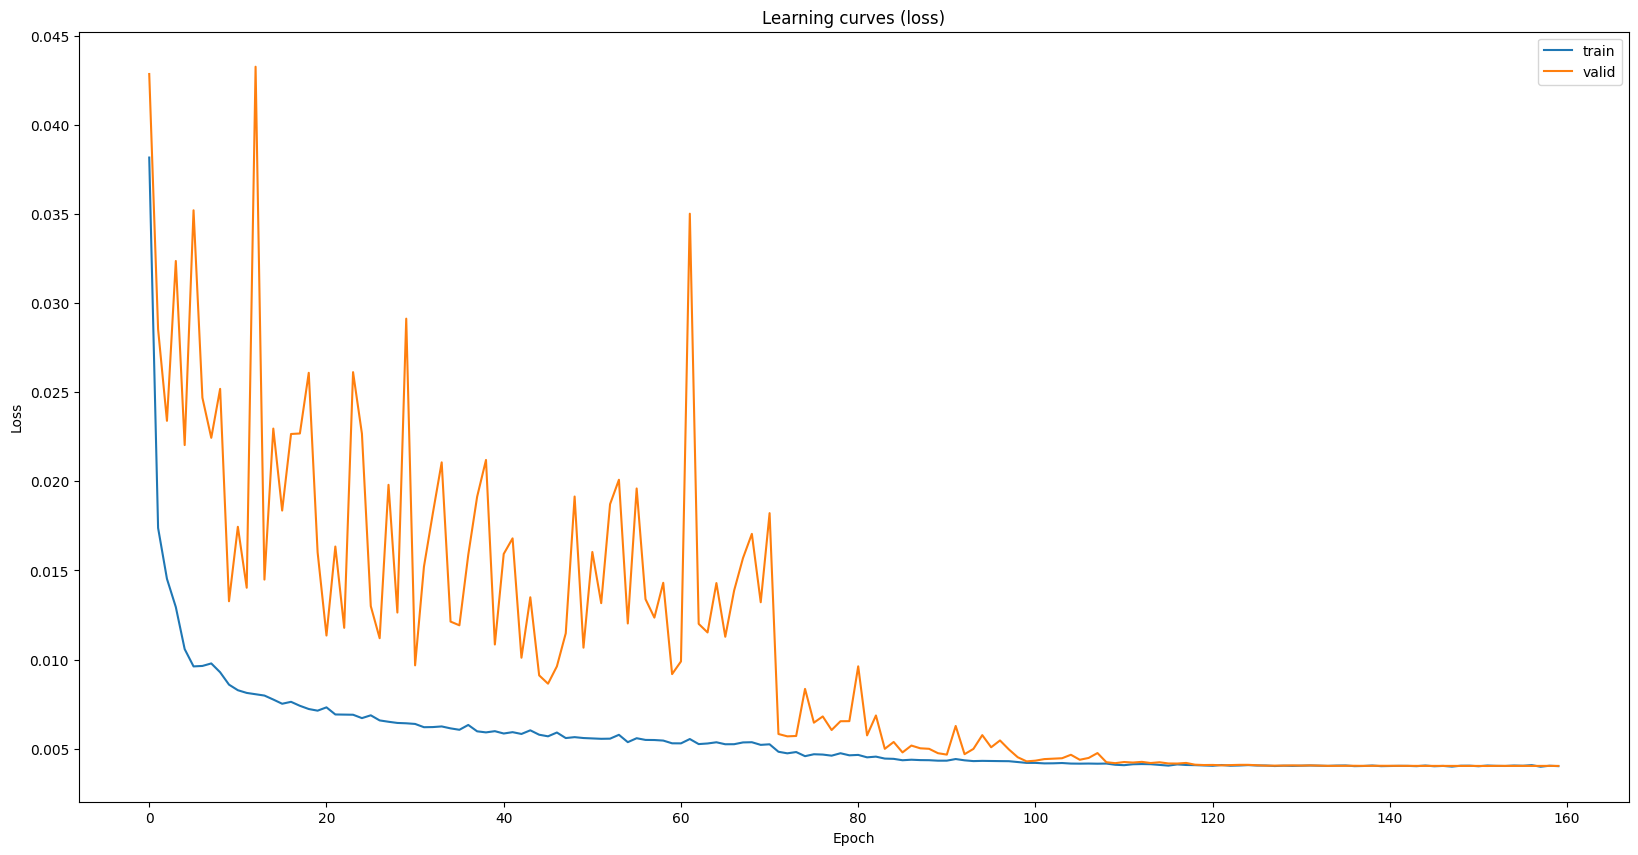

In [6]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 1, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

plt.show()

Looking at the generated images, we can see that we more of the internal features of the jellyfish, but it still looks like something taken through a dirty lense.

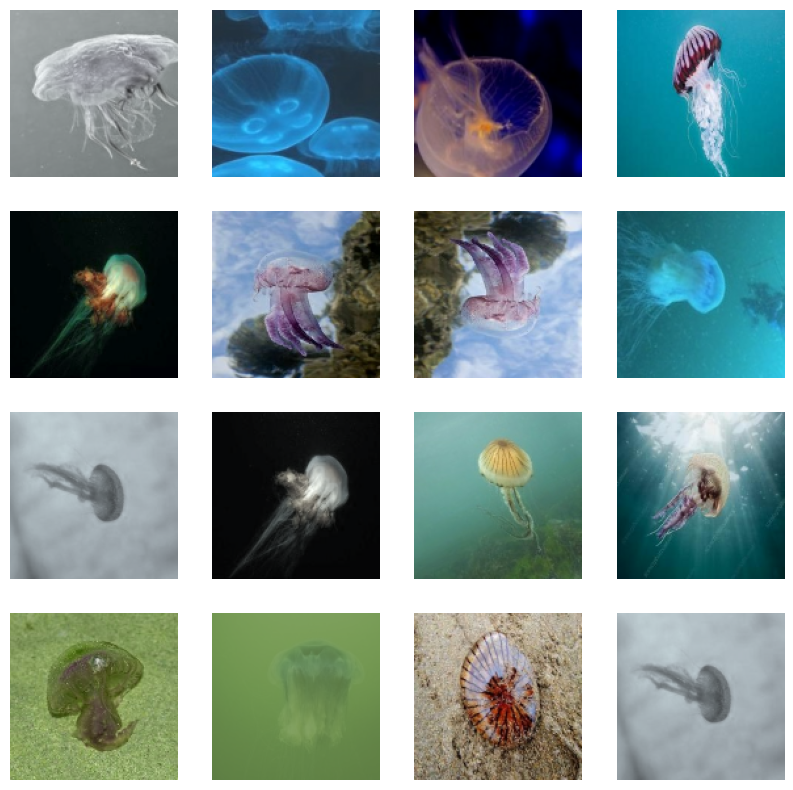

In [7]:
random_jellyfish = [X_train[np.random.randint(0, len(X_test)), :, :, :] for i in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(random_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

1/1 [==============================] - 1s 675ms/step


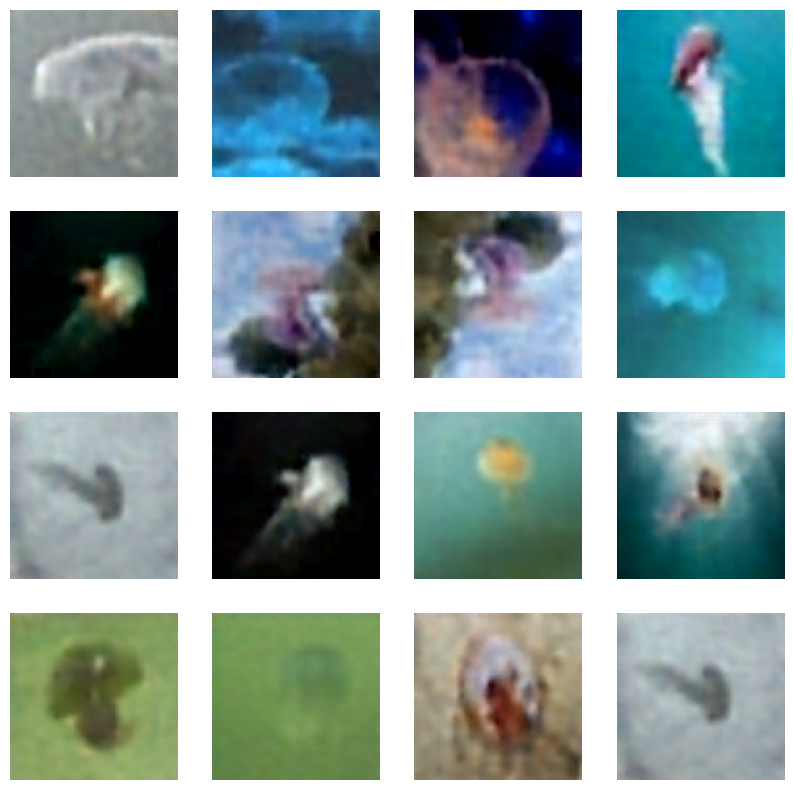

In [8]:
reconstructed_jellyfish = cnn.predict(np.array(random_jellyfish))

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(reconstructed_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

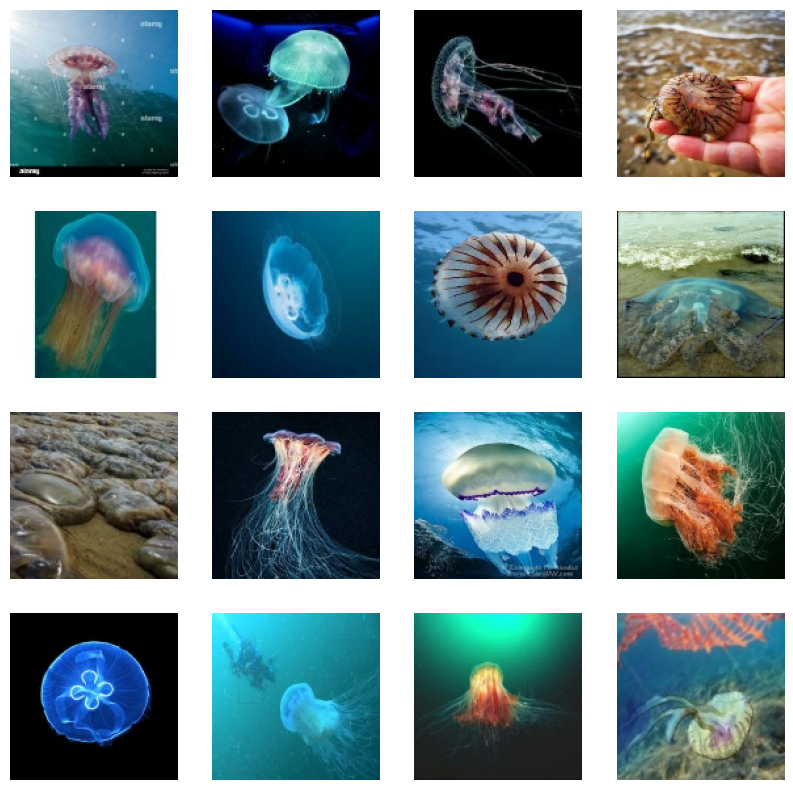

In [9]:
random_jellyfish = [X_test[np.random.randint(0, len(X_test)), :, :, :] for i in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(random_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

1/1 [==============================] - 0s 21ms/step


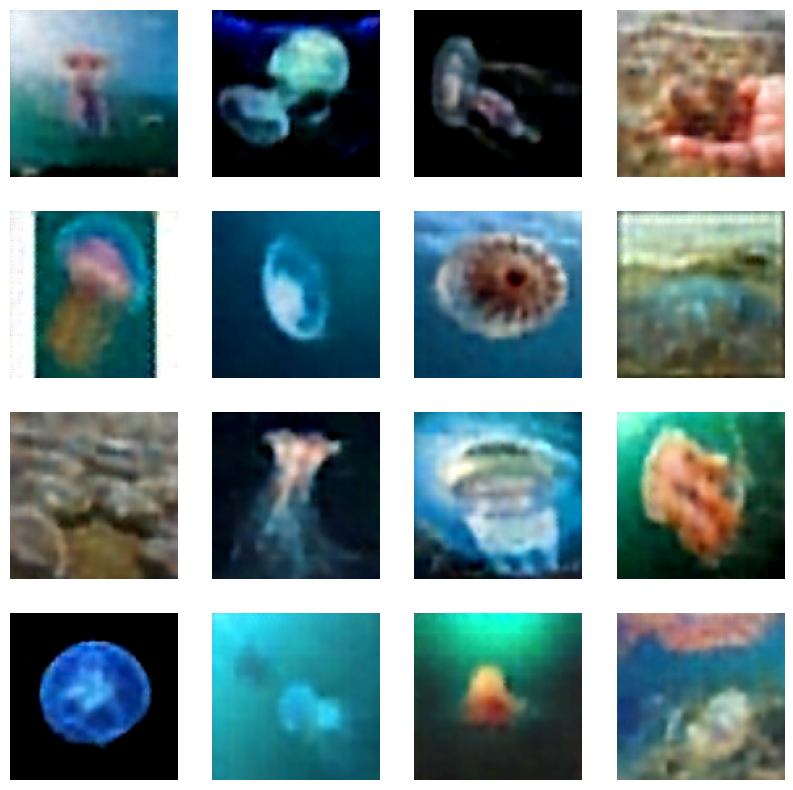

In [10]:
reconstructed_jellyfish = cnn.predict(np.array(random_jellyfish))

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(reconstructed_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)